## Tune the model to higher firing rate

In [8]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.loader import DataLoader

sys.path.append("..")
from spiking_network.models import SpikingModel
from spiking_network.utils import simulate, tune, sparse_to_dense
from spiking_network.datasets import W0Dataset, GlorotParams
from spiking_network.plotting import visualize_spikes, visualize_weights, visualize_time_dependence

In [2]:
# Create a dataset of random connectivity matrices to train on
n_neurons = 100
n_datasets = 5
w0_dataset = W0Dataset(n_neurons, n_datasets, GlorotParams(0, 5))

data_loader = DataLoader(w0_dataset, batch_size=1, shuffle=False)

In [3]:
# Create a model to tune
model = SpikingModel(tuneable_parameters=["threshold", "alpha", "beta"])

# Train the model
for batch_idx, batch in enumerate(data_loader):
    tune(model, batch, firing_rate=0.1, n_steps=100)

Tuning... fr=0.09285: 100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


In [4]:
# Create a dataset of random connectivity matrices to test on
n_neurons = 100
n_datasets = 10
w0_dataset = W0Dataset(n_neurons, n_datasets, GlorotParams(0, 5))

data_loader = DataLoader(w0_dataset, batch_size=1, shuffle=False)

# Test the model
results = []
for batch_idx, batch in enumerate(data_loader):
    X = simulate(model, batch, n_steps=10000)
    results.append(X)

100%|██████████| 10000/10000 [00:03<00:00, 3326.61it/s]


In [5]:
# Calculate the firing rate of the model on the test set
fr = torch.mean(torch.stack([torch.sum(X)/(torch.prod(torch.tensor(X.shape))) for X in results]), dim=0)
print(f"Average firing rate for simulations: {fr.item():.5f}")

Average firing rate for simulations: 0.10765


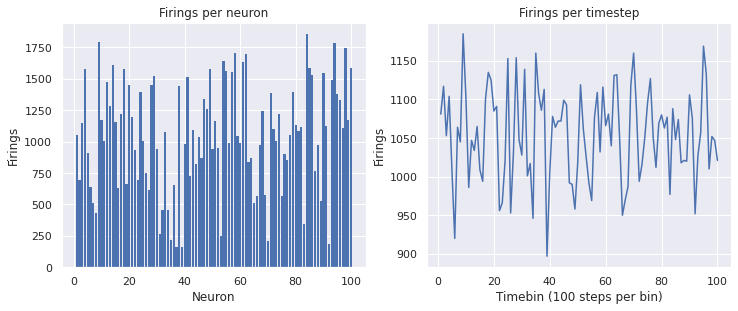

In [6]:
# Plot the results for the first simulation
visualize_spikes(results[0])

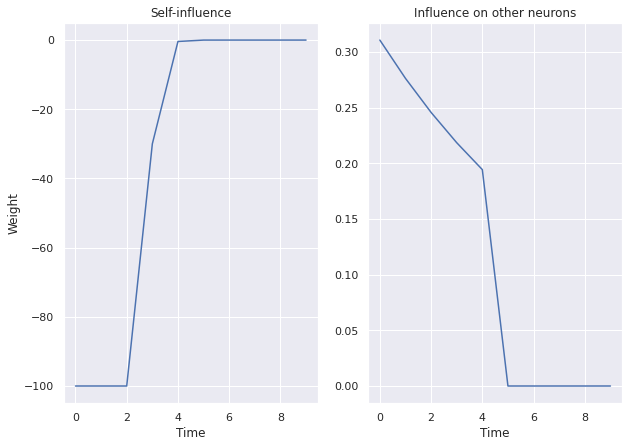

In [12]:
# Visualize the time dependence of the model
W = sparse_to_dense(model.connectivity_filter(w0_dataset[0].W0, w0_dataset[0].edge_index).detach(), w0_dataset[0].edge_index)
visualize_time_dependence(W)